I. Import Packages

In [1]:
#Importing functions library

import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

II. Creating Separate Functions for Aieline Delay Prediction

In [2]:
# DONT REALLY UNDERSTAND THE CODE FOR THIS PART VERY WELL 
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

In [3]:
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

In [4]:
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_heure(cols))
        else:
            cols[1] = format_heure(cols[1])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

III. Data Wraggling for Flights Dataset

In [5]:
#Importing Flight dataset as flights_df

flights_df = pd.read_csv("Flights.csv")
flights_df.head(50)

# Changing Dates and Times YEAR MOTNH DAY
flights_df["DATE"] = pd.to_datetime(flights_df[["YEAR",'MONTH','DAY']])


In [6]:
# Information on raw data 
print(flights_df.columns)

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DATE'],
      dtype='object')


In [7]:
#Information on Column Types and No of Null Values
tab_info=pd.DataFrame(flights_df.dtypes).T.rename(index={0:'Column Type'})
tab_info=tab_info.append(pd.DataFrame(flights_df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(flights_df.isnull().sum()/flights_df.shape[0]*100).T.rename(index={0:'null values (%)'}))
tab_info

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE
Column Type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64,datetime64[ns]
null values (nb),0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640,0
null values (%),0,0,0,0,0,0,0.252978,0,0,0,1.48053,1.48053,1.53026,1.53026,0.000103109,1.80563,1.80563,0,1.58982,1.58982,0,1.58982,1.80563,0,0,98.4554,81.725,81.725,81.725,81.725,81.725,0


In [8]:
#Splitting data into 2 subsets - Arrival (arr_df) and Departure (dep_df)
arr_df = flights_df[['DATE', 'DAY_OF_WEEK','AIRLINE','FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_ARRIVAL', "ARRIVAL_TIME", "ARRIVAL_DELAY"]]
print(arr_df.head(3))
dep_df = flights_df[['DATE', 'DAY_OF_WEEK','AIRLINE','FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT','DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', "DEPARTURE_DELAY"]]
print(dep_df.head(3))

#how come drop flight number? if flight number unique, link to origin and destination airport later?
#I feel the flight number is quite unique and there is little value to include it
#is flight number unique? if repeated - groupby?
# need to include departure airport in arr_df? - possible delay by flight duration vs landing duration 


        DATE  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER ORIGIN_AIRPORT  \
0 2015-01-01            4      AS             98      N407AS            ANC   
1 2015-01-01            4      AA           2336      N3KUAA            LAX   
2 2015-01-01            4      US            840      N171US            SFO   

  DESTINATION_AIRPORT  SCHEDULED_ARRIVAL  ARRIVAL_TIME  ARRIVAL_DELAY  
0                 SEA                430         408.0          -22.0  
1                 PBI                750         741.0           -9.0  
2                 CLT                806         811.0            5.0  
        DATE  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER ORIGIN_AIRPORT  \
0 2015-01-01            4      AS             98      N407AS            ANC   
1 2015-01-01            4      AA           2336      N3KUAA            LAX   
2 2015-01-01            4      US            840      N171US            SFO   

  DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_TIME  DEPARTURE_DELAY  


In [9]:
#Data Cleaning for Flights for arr_df

# Removing the rows with null values 
# Remove rows with missing "ARRIVAL_TIME" & "ARRIVAL_DELAY" from arr_df
arr_df = arr_df.dropna(axis = 0 , subset = ['ARRIVAL_TIME', 'ARRIVAL_DELAY'])

# Adding boolean column: Delay = 1, No delay (Early/Punctual) = 0
#cond_early_arr = arr_df["ARRIVAL_DELAY"] < 0
#cond_punctual_arr = arr_df['ARRIVAL_DELAY'] == 0
arr_df["DELAY"] = np.where(arr_df['ARRIVAL_DELAY'] <= 0, "0", "1")
arr_df.head()

# Qn: Remove rows with missing flight number? - tracing to whether the flight is 

,DATE,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DELAY
0,2015-01-01,4,AS,98,N407AS,ANC,SEA,430,408.0,-22.0,0
1,2015-01-01,4,AA,2336,N3KUAA,LAX,PBI,750,741.0,-9.0,0
2,2015-01-01,4,US,840,N171US,SFO,CLT,806,811.0,5.0,1
3,2015-01-01,4,AA,258,N3HYAA,LAX,MIA,805,756.0,-9.0,0
4,2015-01-01,4,AS,135,N527AS,SEA,ANC,320,259.0,-21.0,0


In [10]:
#Data Cleaning for Flights for dep_df
dep_df = dep_df.dropna(axis = 0 , subset = ['DEPARTURE_TIME', 'DEPARTURE_DELAY'])

# Adding boolean column: Delay = 1, No delay (Early/Punctual) = 0
#cond_early_arr = arr_df["ARRIVAL_DELAY"] < 0
#cond_punctual_arr = arr_df['ARRIVAL_DELAY'] == 0
dep_df["DELAY"] = np.where(dep_df['DEPARTURE_DELAY'] <= 0, "0", "1")
dep_df.head()

#Will departure delay affect arrival delay? 
#Should we minus the departure delay from arrival delay to not double penalise the delay?
#That is a very good question but I am not too sure after we have removed them, how can we actually find out the difference between the flights that has arrival delay that is longer than the departure delay for the 
    #dataset right, it actually have one column named as arrival delay and the other named as departure delay

,DATE,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,DELAY
0,2015-01-01,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,0
1,2015-01-01,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,0
2,2015-01-01,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,0
3,2015-01-01,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,0
4,2015-01-01,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,0


In [11]:
#Convert the dataframe variables for this part 
#arr_df['SCHEDULED_ARRIVAL'] = create_flight_time(arr_df, 'SCHEDULED_ARRIVAL')
#arr_df['ARRIVAL_TIME'] = arr_df['ARRIVAL_TIME'].apply(format_heure)

#dep_df['DEPARTURE_TIME'] = dep_df['DEPARTURE_TIME'].apply(format_heure)
#dep_df['SCHEDULED_DEPARTURE'] = dep_df['SCHEDULED_DEPARTUREL'].apply(format_heure)

IV. Data Wraggling on Airports Dataset

In [12]:
# Importing airport dataset as airports_df
airports_df = pd.read_csv("airports.csv")
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


V. Data Wraggling on Airline Dataset

In [13]:
# Importing airlines dataset as airlines_df
airlines_df = pd.read_csv("airlines.csv")
airlines_df.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


VI. Data Exploration on Flights CSV

In [14]:
# !! Proportion of delayed flights for arr_df
# Counting the number of flights per airline
arr_df_groupby_flights = arr_df.groupby("AIRLINE")
arr_df_flight_count = arr_df_groupby_flights.size().reset_index(name = "Number of Flights")
arr_df_flight_count

,AIRLINE,Number of Flights
0,AA,712935
1,AS,171439
2,B6,262042
3,DL,870275
4,EV,554752
5,F9,90090
6,HA,76041
7,MQ,278791
8,NK,115193
9,OO,576814


In [15]:
# Counting number of delays per airline
cond_arr_delay = arr_df["DELAY"] == "1"
arr_df_delay = arr_df[cond_arr_delay]
arr_df_delay_groupby_flights = arr_df_delay.groupby("AIRLINE")
arr_df_delay_count = arr_df_delay_groupby_flights.size().reset_index(name = "Number of Delay" )
arr_df_delay_count

,AIRLINE,Number of Delay
0,AA,252191
1,AS,56953
2,B6,101998
3,DL,250840
4,EV,213217
5,F9,41232
6,HA,30179
7,MQ,103505
8,NK,56887
9,OO,222435


In [16]:
# Calculating proportion of delay 
# No of delays/ No of flights per airline

by_airline = pd.merge(arr_df_flight_count, arr_df_delay_count)

by_airline["Proportion of Delay"] = arr_df_delay_count["Number of Delay"] / arr_df_flight_count["Number of Flights"]
by_airline


,AIRLINE,Number of Flights,Number of Delay,Proportion of Delay
0,AA,712935,252191,0.353736
1,AS,171439,56953,0.332206
2,B6,262042,101998,0.389243
3,DL,870275,250840,0.288231
4,EV,554752,213217,0.384347
5,F9,90090,41232,0.457676
6,HA,76041,30179,0.396878
7,MQ,278791,103505,0.371264
8,NK,115193,56887,0.493841
9,OO,576814,222435,0.385627


In [17]:
#Features of Cleaned Datasets 

# A) Arrival Delays - Data types, Dimension
print("Data Types:", arr_df.dtypes)
print("Dataframe Dimensions:", arr_df.shape)

Data Types: DATE                   datetime64[ns]
DAY_OF_WEEK                     int64
AIRLINE                        object
FLIGHT_NUMBER                   int64
TAIL_NUMBER                    object
ORIGIN_AIRPORT                 object
DESTINATION_AIRPORT            object
SCHEDULED_ARRIVAL               int64
ARRIVAL_TIME                  float64
ARRIVAL_DELAY                 float64
DELAY                          object
dtype: object
Dataframe Dimensions: (5714008, 11)


In [18]:
# !! Proportion of delayed flights for dep_df
# Counting the number of flights per airline
dep_df_groupby_flights = dep_df.groupby("AIRLINE")
dep_df_flight_count = dep_df_groupby_flights.size().reset_index(name = "Number of Flights")
dep_df_flight_count

,AIRLINE,Number of Flights
0,AA,715598
1,AS,171910
2,B6,262843
3,DL,872177
4,EV,557294
5,F9,90290
6,HA,76119
7,MQ,280282
8,NK,115454
9,OO,579086


In [19]:
# Counting number of delays per airline
cond_arr_delay = dep_df["DELAY"] == "1"
dep_df_delay = dep_df[cond_arr_delay]
dep_df_delay_groupby_flights = dep_df_delay.groupby("AIRLINE")
dep_df_delay_count = dep_df_delay_groupby_flights.size().reset_index(name = "Number of Delay" )
dep_df_delay_count

,AIRLINE,Number of Delay
0,AA,245904
1,AS,43566
2,B6,102061
3,DL,282463
4,EV,169897
5,F9,34893
6,HA,20146
7,MQ,93726
8,NK,52089
9,OO,171572


In [20]:
# Calculating proportion of delay 
# No of delays/ No of flights per airline

by_airline = pd.merge(dep_df_flight_count, dep_df_delay_count)

by_airline["Proportion of Delay"] = dep_df_delay_count["Number of Delay"] / dep_df_flight_count["Number of Flights"]
by_airline

,AIRLINE,Number of Flights,Number of Delay,Proportion of Delay
0,AA,715598,245904,0.343634
1,AS,171910,43566,0.253423
2,B6,262843,102061,0.388296
3,DL,872177,282463,0.323860
4,EV,557294,169897,0.304861
5,F9,90290,34893,0.386455
6,HA,76119,20146,0.264665
7,MQ,280282,93726,0.334399
8,NK,115454,52089,0.451167
9,OO,579086,171572,0.296281


In [21]:
#Features of Cleaned Datasets 

# A) Arrival Delays - Data types, Dimension
print("Data Types:", dep_df.dtypes)
print("Dataframe Dimensions:", dep_df.shape)

Data Types: DATE                   datetime64[ns]
DAY_OF_WEEK                     int64
AIRLINE                        object
FLIGHT_NUMBER                   int64
TAIL_NUMBER                    object
ORIGIN_AIRPORT                 object
DESTINATION_AIRPORT            object
SCHEDULED_DEPARTURE             int64
DEPARTURE_TIME                float64
DEPARTURE_DELAY               float64
DELAY                          object
dtype: object
Dataframe Dimensions: (5732926, 11)


#Exploratory Data Analysis

KeyError: 'SCHEDULED_DEPARTURE'

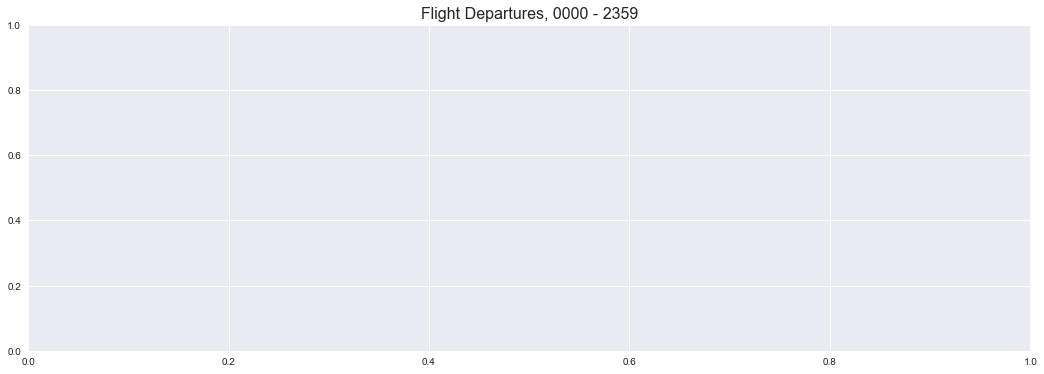

In [23]:
#ERROR
#Visualizing Number of Flights at Different Departure Timing 
DIMS = (16,6)
sns.set()

fig = plt.figure(figsize = DIMS)
ax1 = fig.add_subplot(111)

ax1.set_title("Flight Departures, 0000 - 2359", fontsize = 16)
dep_df_flight_count.plot(kind = "line", 
                  x = 'SCHEDULED_DEPARTURE', 
                  y = 'No of flights departing', 
                  ax = ax1, 
                  marker = 'o'
)

plt.xticks(np.arange(0,2359))
plt.xlabel("Timing")

plt.yticks(np.arange(1,2815))
plt.ylabel("No of Flights Departing")

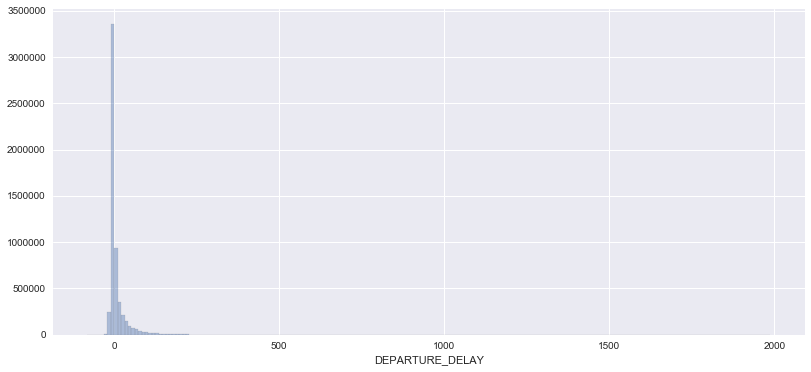

In [25]:
#Visualizing Number of delays in 4 bins 25%,50%,75%,100%fig for dep_df
# ax1 = plt.subplots(figsize = (12,6))
fig,ax1 = plt.subplots(figsize = (12,6))

sns.distplot(
    dep_df["DEPARTURE_DELAY"],
    kde = False, 
    bins = 200, 
    ax = ax1
)

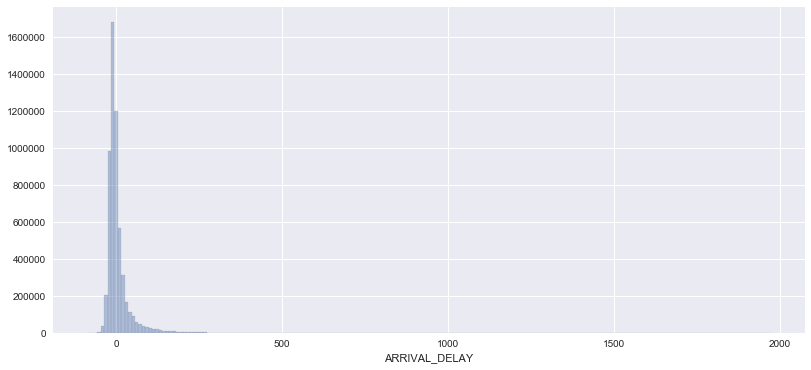

In [27]:
#Visualizing Number of delays in 4 bins 25%,50%,75%,100%fig for arr_df
# ax1 = plt.subplots(figsize = (12,6))
fig,ax1 = plt.subplots(figsize = (12,6))

sns.distplot(
    arr_df["ARRIVAL_DELAY"],
    kde = False, 
    bins = 200, 
    ax = ax1
)

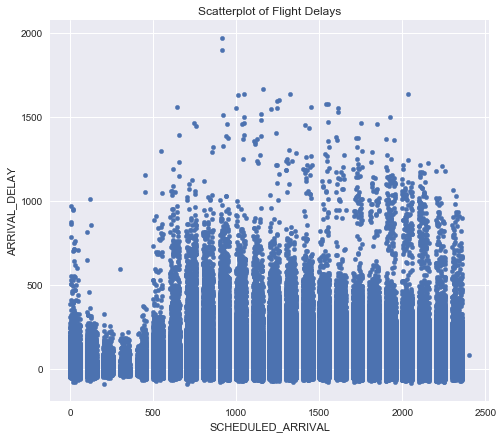

In [28]:
# Plot scatter plot for arr_df

fig, ax1 = plt.subplots()
arr_df.plot(
    kind='scatter', ax=ax1,
    title='Scatterplot of Flight Delays',
    x='SCHEDULED_ARRIVAL', y='ARRIVAL_DELAY',
    figsize=(7, 7),)
ax1.set_ylabel("ARRIVAL_DELAY")
plt.show()


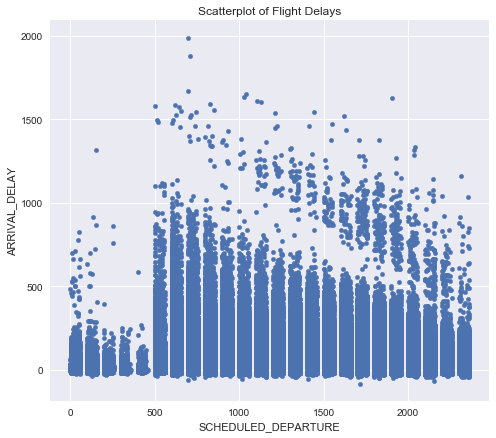

In [31]:
# Plot scatter plot for dep_df

fig, ax1 = plt.subplots()
dep_df.plot(
    kind='scatter', ax=ax1,
    title='Scatterplot of Flight Delays',
    x='SCHEDULED_DEPARTURE', y='DEPARTURE_DELAY',
    figsize=(7, 7),)
ax1.set_ylabel("ARRIVAL_DELAY")
plt.show()


In [38]:
#analyse missing pattern - matplotlib 
#Removing Outliers for Arrival Delay

quartile_1 = np.percentile(arr_df["ARRIVAL_DELAY"],25) #cannot run the whole sample
quartile_3 = np.percentile(arr_df["ARRIVAL_DELAY"], 75)
print(quartile_1)
print(quartile_3)

iqr = quartile_3 - quartile_1
print(iqr)

lower_bound = quartile_1 - 1.5*iqr
upper_bound = quartile_3 + 1.5*iqr

arr_df[(arr_df['ARRIVAL_DELAY'] < lower_bound) | (arr_df['ARRIVAL_DELAY'] > upper_bound)].sort_values(['ARRIVAL_DELAY'])

-13.0
8.0
21.0


,DATE,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DELAY
1093297,2015-03-12,4,US,693,N910AW,HNL,PHX,705,538.0,-87.0,0
1467349,2015-04-04,6,AA,2483,N3HAAA,PHX,DFW,207,40.0,-87.0,0
316347,2015-01-21,3,AS,11,N467AS,EWR,SEA,2049,1927.0,-82.0,0
4535993,2015-10-10,6,VX,165,N636VA,11618,12892,1550,1429.0,-81.0,0
1836251,2015-04-27,1,UA,1225,N53442,EWR,LAX,2250,2129.0,-81.0,0
3627775,2015-08-13,4,AA,60,N634AA,DFW,MIA,32,2312.0,-80.0,0
5645762,2015-12-20,7,AS,161,N793AS,ADK,ANC,2100,1940.0,-80.0,0
5136512,2015-11-17,2,AA,211,N3CFAA,JFK,LAS,1957,1837.0,-80.0,0
4538501,2015-10-10,6,DL,420,N624AG,12478,12892,1857,1738.0,-79.0,0
561640,2015-02-06,5,DL,1104,N140LL,HNL,SLC,711,552.0,-79.0,0


In [40]:
#analyse missing pattern - matplotlib 
#Removing Outliers for Departure Delay

quartile_1 = np.percentile(dep_df["DEPARTURE_DELAY"],25) #cannot run the whole sample
quartile_3 = np.percentile(dep_df["DEPARTURE_DELAY"], 75)
print(quartile_1)
print(quartile_3)

iqr = quartile_3 - quartile_1
print(iqr)

lower_bound = quartile_1 - 1.5*iqr
upper_bound = quartile_3 + 1.5*iqr

dep_df[(dep_df['DEPARTURE_DELAY'] < lower_bound) | (dep_df['DEPARTURE_DELAY'] > upper_bound)].sort_values(['DEPARTURE_DELAY'])

-5.0
7.0
12.0


,DATE,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,DELAY
5645762,2015-12-20,7,AS,161,N793AS,ADK,ANC,1715,1553.0,-82.0,0
1467349,2015-04-04,6,AA,2483,N3HAAA,PHX,DFW,2150,2042.0,-68.0,0
697022,2015-02-16,1,DL,1210,N301DQ,HSV,ATL,700,559.0,-61.0,0
4264477,2015-09-23,3,OO,7369,N457SW,APN,DTW,1017,921.0,-56.0,0
5719709,2015-12-25,5,EV,5220,N859AS,GSO,ATL,1405,1310.0,-55.0,0
2433467,2015-06-03,3,DL,665,N305DQ,ATL,EYW,1909,1817.0,-52.0,0
397316,2015-01-27,2,OO,4718,N443SW,SBN,MSP,735,647.0,-48.0,0
5301847,2015-11-28,6,AS,66,N779AS,YAK,JNU,1830,1742.0,-48.0,0
270990,2015-01-18,7,AS,66,N788AS,YAK,JNU,1830,1743.0,-47.0,0
4152238,2015-09-16,3,F9,295,N924FR,TPA,DEN,730,644.0,-46.0,0


KeyError: 'AS'

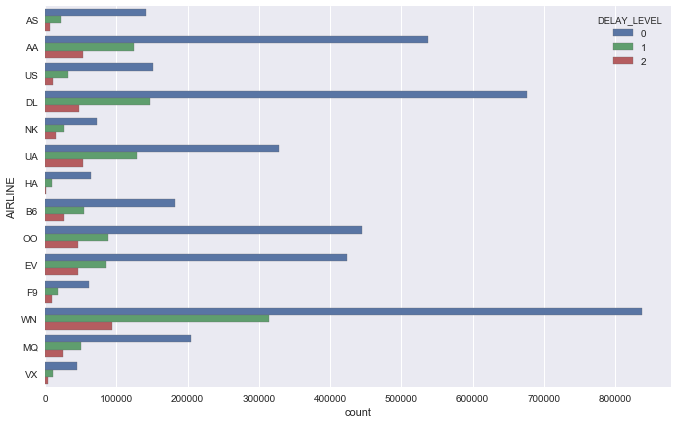

In [45]:
#Plotting the distribution of the flight count for delay for all airlines 
#Need to reformat the airline names
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
dep_df['DELAY_LEVEL'] = dep_df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=dep_df)

# We replace the abbreviations by the full names of the companies and set the labels
labels = [airlines_df[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)


# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

In [46]:
#Plotting the Delay Distribution Across All Airlines
#ERROR
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), normed=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()

NameError: name 'global_stats' is not defined

<Figure size 792x792 with 0 Axes>

IndexError: list index out of range

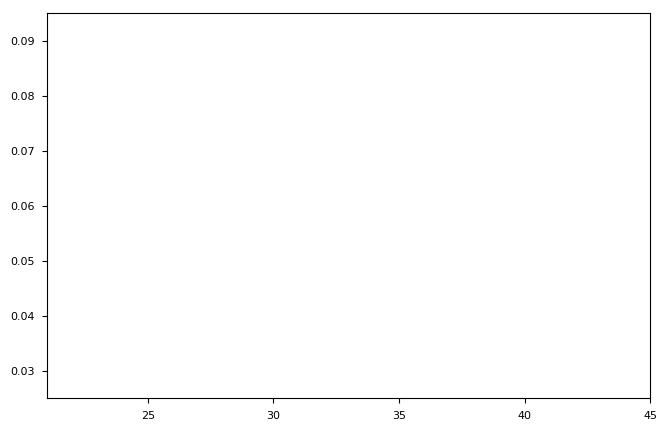

In [49]:
#Plotting Delay Distribution Using b Parameter 
#Error
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_context('paper')
import matplotlib.patches as patches

fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(14)]
y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -2.5/1000
y_shift[5] = 1/1000
x_val = [s[1] for s in points]
y_val = [s[0] for s in points]

gs=GridSpec(2,7)
#_______________________________

# Main Title
ax1.text(.5,1.5,'Characterizing delays \n among companies', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center',
        transform=ax1.transAxes)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax1.spines[k].set_visible(True)
    ax1.spines[k].set_linewidth(0.5)
    ax1.spines[k].set_color('k')
#____________________
# Create a Rectangle 
rect = patches.Rectangle((21,0.025), 19, 0.07, linewidth=2,
                         edgecolor='r', linestyle=':', facecolor='none')
ax1.add_patch(rect)
#_______________________________________________
# 2/ Zoom on the bulk of carriers (right panel)
ax2=fig.add_subplot(gs[0:2,2:])
plt.scatter(x=x_val, y=y_val, marker = 's', edgecolor='black', linewidth = '1')
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21,45)
ax2.set_ylim(0.025,0.095)
#________________
# Company labels
for i in range(len(airlines_df)):
    ax2.annotate(label_company[i], xy=(x_val[i]+0.5, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)
#____________________________
# Increasing delay direction
ax2.arrow(30, 0.09, 8, -0.03, head_width=0.005,
          shape = 'full', head_length=2, fc='k', ec='k')
ax2.annotate('increasing \n  delays', fontsize= 20, color = 'r',
          xy=(35, 0.075), xycoords='data')
#________________________________
# position and size of the ticks
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)
#________________________
# plot border parameters
for k in ['top', 'bottom', 'right', 'left']:
    ax2.spines[k].set_visible(True)
    ax2.spines[k].set_linewidth(0.5)
    ax2.spines[k].set_color('k')    
#________________________________
# Connection between the 2 plots
xy2 = (40, 0.09) ; xy1 = (21, 0.095)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
xy2 = (40, 0.025) ; xy1 = (21, 0.025)
con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1,
                      linestyle=':', linewidth = 2, color="red")
ax2.add_artist(con)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
#--------------------------------
plt.show()